In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.ticker
import matplotlib.dates

In [2]:
path = 'eshail2_pwr_2019-03-01T17:25:13.532121.3xf32'
x = np.fromfile(path, dtype='float32')
x = x[:x.size//3*3]
x = x.reshape((-1,3))

In [3]:
start = np.datetime64(path.strip('.3xf32').split('_')[-1])
time = start + np.timedelta64(100, 'ms') * np.arange(x.shape[0])
powers = xr.Dataset({'digital' : (['time'], x[:,0]),
                     'cw' : (['time'], x[:,1]),
                     'transponder_noise' : (['time'], x[:,2])},
                   coords = {'time' : time})

In [4]:
powers_1min = powers.resample(time = '1min').mean()
powers_1min_max = powers.resample(time = '1min').max()

In [5]:
bias = 10*np.log10(np.average(powers_1min['transponder_noise']))

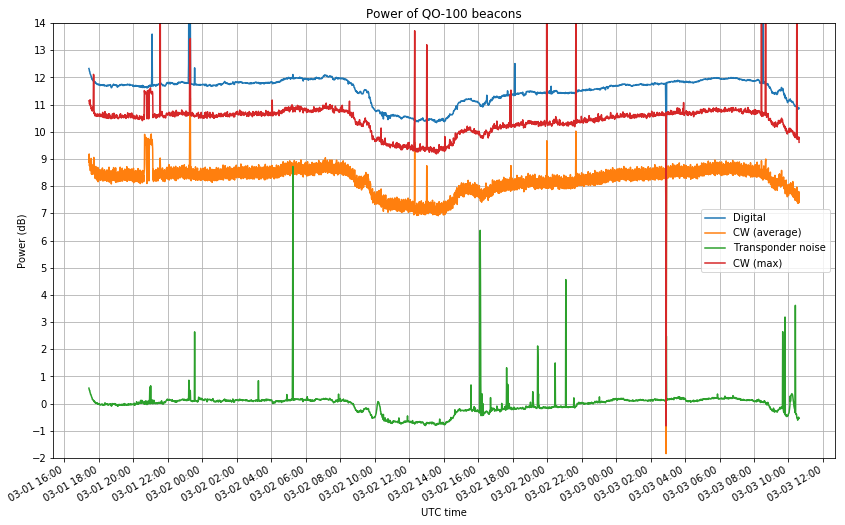

In [6]:
plt.figure(figsize = (14,8), facecolor = 'w')
pdB = 10*np.log10(powers_1min) - bias
for p in pdB.values():
    p.plot()
(10*np.log10(powers_1min_max['cw']) - bias).plot()
plt.legend(['Digital', 'CW (average)', 'Transponder noise', 'CW (max)'])
plt.grid()
plt.ylabel('Power (dB)')
plt.xlabel('UTC time')
plt.title('Power of QO-100 beacons');
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(matplotlib.dates.HourLocator(np.arange(0,24,2)))
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d %H:%M'))
plt.ylim([-2,14]);

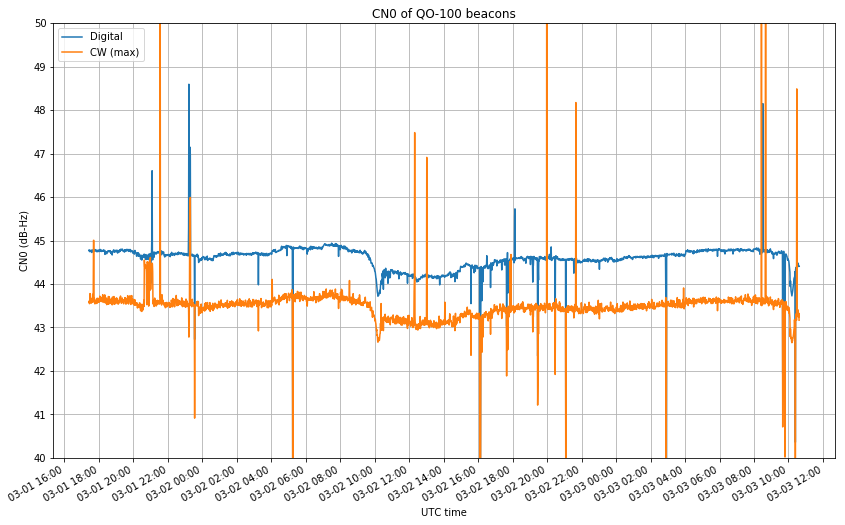

In [7]:
plt.figure(figsize = (14,8), facecolor = 'w')
noise_bw = 2000
noise = 10*np.log10(noise_bw)
(10*np.log10(powers_1min['digital']) - 10*np.log10(powers_1min['transponder_noise']) + noise).plot()
(10*np.log10(powers_1min_max['cw']) - 10*np.log10(powers_1min['transponder_noise']) + noise).plot()
#plt.legend(['Digital', 'CW (average)', 'Transponder noise', 'CW (max)'])
plt.grid()
plt.ylabel('CN0 (dB-Hz)')
plt.xlabel('UTC time')
plt.title('CN0 of QO-100 beacons');
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(matplotlib.dates.HourLocator(np.arange(0,24,2)))
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d %H:%M'))
plt.ylim([40,50]);
plt.legend(['Digital', 'CW (max)']);